# Transformers fine tuning on IMDB for sentiment

* https://huggingface.co/transformers/training.html
  * https://huggingface.co/transformers/training.html#fine-tuning-with-keras
* https://huggingface.co/docs/datasets/
* https://github.com/huggingface/datasets
* https://huggingface.co/datasets/imdb

_"We will show you how to fine-tune BERT on the IMDB dataset: the task is to classify whether movie reviews are positive or negative."_

## Installation

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

In [3]:
# https://huggingface.co/transformers/installation.html
# !pip install -q transformers 

In [4]:
# https://huggingface.co/docs/datasets/installation.html
# !pip install -q datasets

## Get and prepare data

In [5]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

Reusing dataset imdb (/home/olli/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


In [6]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [8]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Loading cached processed dataset at /home/olli/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-cc1eb1e0c43ebb9a.arrow
Loading cached processed dataset at /home/olli/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-6613375047469b44.arrow
Loading cached processed dataset at /home/olli/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-063970e4500da1bb.arrow


In [9]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 50000
    })
})

In [10]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]

Loading cached shuffled indices for dataset at /home/olli/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-d74fd49583bc29ae.arrow
Loading cached shuffled indices for dataset at /home/olli/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-ff8cc48f84bd17b1.arrow


In [11]:
small_train_dataset.shape

(1000, 5)

In [12]:
small_train_dataset[0].keys()

dict_keys(['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'])

In [13]:
tf_train_dataset = small_train_dataset.remove_columns(["text"]).with_format("tensorflow")
tf_eval_dataset = small_eval_dataset.remove_columns(["text"]).with_format("tensorflow")

In [14]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

## Get pretrained model and fine tune

In [15]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 60-90 seconds on decent GPU
# don't train for too long, model will overfit
EPOCHS = 5
# reduce batch size when you encoder OOM error
# note, model has more than 100M parameters
# batch size 8 doable on 16GB
BATCH_SIZE = 8
# don't forget, we are fine tuning, increasing the LR might even increase overfitting
LR = 5e-5

In [17]:
train_features = {x: tf_train_dataset[x].to_tensor() for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, tf_train_dataset["label"]))
train_tf_dataset = train_tf_dataset.shuffle(len(tf_train_dataset)).batch(BATCH_SIZE)

eval_features = {x: tf_eval_dataset[x].to_tensor() for x in tokenizer.model_input_names}
eval_tf_dataset = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["label"]))
eval_tf_dataset = eval_tf_dataset.batch(8)

In [18]:
%%time

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
)

history = model.fit(train_tf_dataset, validation_data=eval_tf_dataset, epochs=EPOCHS)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
125/125 [==============================] - 103s 739ms/step - loss: 0.7078 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6985 - val_sparse_categorical_accuracy: 0.4970
Epoch 2/3
125/125 [==============================] - 90s 725ms/step - loss:

## Evaluate results

In [19]:
model.evaluate(train_tf_dataset)

125/125 [==============================] - 23s 183ms/step - loss: 0.4767 - sparse_categorical_accuracy: 0.7560


[0.4767046868801117, 0.7559999823570251]

In [20]:
# training data set too small to not overfit on it
model.evaluate(eval_tf_dataset)

125/125 [==============================] - 23s 183ms/step - loss: 0.5538 - sparse_categorical_accuracy: 0.7140


[0.5537927150726318, 0.7139999866485596]

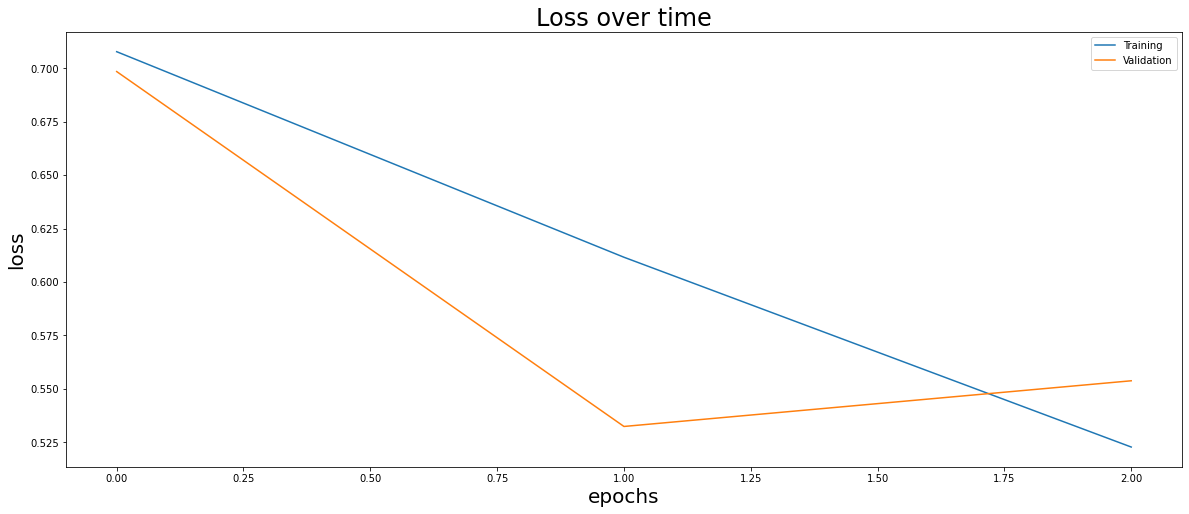

In [21]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

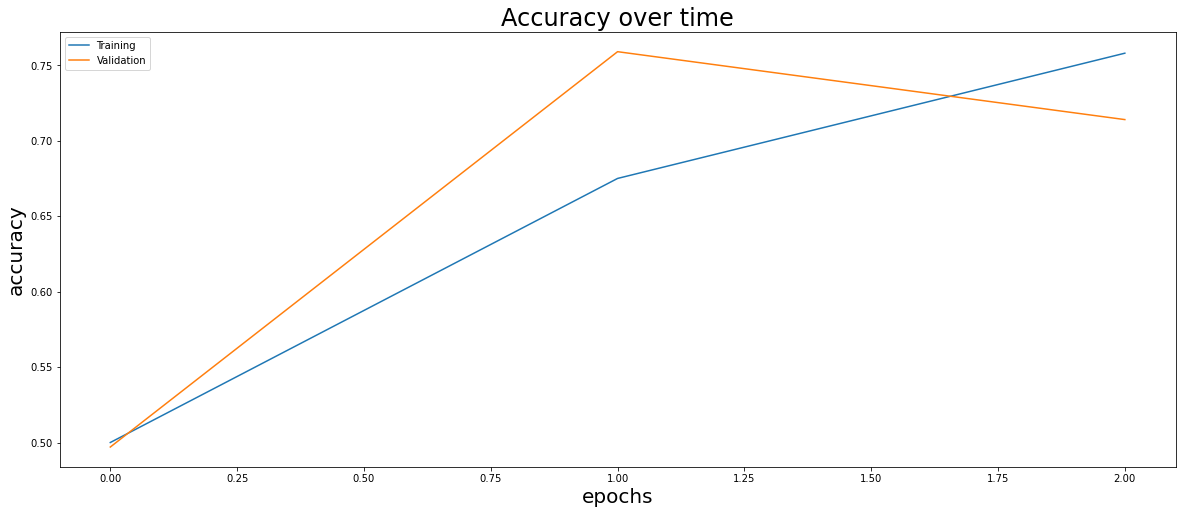

In [22]:
# plt.yscale('log')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['sparse_categorical_accuracy']);
plt.plot(history.history['val_sparse_categorical_accuracy']);

plt.legend(['Training', 'Validation']);


## Try out our fine tuned model

Quoting from https://huggingface.co/datasets/imdb
* neg: 0
* pos: 1

https://huggingface.co/transformers/task_summary.html#sequence-classification

In [23]:
movie1 = 'Two small cats seek and find adventures'

In [24]:
movie2 = 'Zombies attack a kindergarden'

In [25]:
movies = [movie1, movie2]

In [26]:
inputs = tokenizer(movies, padding="max_length", truncation=True, return_tensors="tf")

In [27]:
# this seems to be a good movie
tf.nn.softmax(model(inputs)[0])[0].numpy()

array([0.59064853, 0.40935147], dtype=float32)

In [28]:
# this one not so much
tf.nn.softmax(model(inputs)[0])[1].numpy()

array([0.5930172 , 0.40698278], dtype=float32)